# Beginner: Zcut and Astroquery Tutorial

This notebook is a beginner tutorial on the Zcut feature of the MAST astroquery interface. Zcut allows you to request cutouts — either as `.fits` or image files — from various deep field surveys. The list of supported deep field surveys can be found here: https://mast.stsci.edu/zcut/

## Goals:
In this tutorial, you'll learn to:

1. Use RA/Dec coordinates to search for surveys containing your target
2. Create a cutout from deep field surveys
3. Download, process, and display:
    * image file cutouts
    * `.fits` cutouts

Let's get started!

## Table of Contents

* [Import Statements](#Import-Statements)
* [Image File Cutouts](#Image-File-Cutouts)
    * [Set up coordinates](#Set-up-coordinates)
    * [Query for Available Surveys](#Query-for-Available-Surveys)
    * [Getting Cutouts](#Getting-Cutouts)
* [FITS cutouts](#Getting-FITS-cutouts)

## Import Statements

There are some modules we need to complete this tutorial, so we start with a few import statements:

 - `astroquery.mast` to query the catalogs and to access Zcut
 - `astropy` for handling coordinates and FITS files
 - `PIL` for colorizing images
 - `matplotlib` to create our plots

In [1]:
# Catalog queries and Zcut
from astroquery.mast import Catalogs, Zcut

# Handling Coordinates/FITS Files
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

# To display images
from PIL import Image

# For matplotlib plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Image File Cutouts
### Set up coordinates

To begin, we we create a SkyCoord object from our known RA and Dec. This is an unambigious, machine-friendly way of storing this information for later use.

In [2]:
coord = SkyCoord(189.49206, 62.20615, unit = "deg")
print(coord)

<SkyCoord (ICRS): (ra, dec) in deg
    (189.49206, 62.20615)>


### Query for Available Surveys

Here we use `get_surveys()` to find the surveys available for our chosen position in the sky. This isn't necessary to get an image file; however, it can be nice to know which surveys we can download from.

In [3]:
survey_list = Zcut.get_surveys(coordinates=coord)
print(survey_list)

['candels_gn_60mas', 'candels_gn_30mas', 'goods_north', '3dhst_goods-n']


### Downloading Image Cutouts

Next, we use `download_cutouts()` to... well, download the cutouts! For this example, we're interested in downloading an image file. The image file options are `.jpg` or `.png`, so let's use `.jpg`. We can also specify the size of the images (in pixels) and our desired survey.

In [4]:
cutoutList = Zcut.download_cutouts(coordinates=coord, size=[500,300], 
                                   cutout_format="jpg", survey="3dhst_goods-n")
print(cutoutList)

Inflating...
                                               Local Path                                               
--------------------------------------------------------------------------------------------------------
   ./hlsp_3dhst_spitzer_irac_goods-n_irac1_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg
./hlsp_3dhst_spitzer_irac_goods-n-s2_irac3_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg
./hlsp_3dhst_spitzer_irac_goods-n-s1_irac4_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg
   ./hlsp_3dhst_spitzer_irac_goods-n_irac2_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg
      ./hlsp_3dhst_mayall_mosaic_goods-n_u_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg
 ./hlsp_3dhst_subaru_suprimecam_goods-n_rc_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg
  ./hlsp_3dhst_subaru_suprimecam_goods-n_v_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg
 ./hlsp_3dhst_subaru_suprimecam_goods-n_ic

This list of filenames looks overwhelming at first glance, but they follow a pattern: HLSP, telescope name, filter, then v4.0, the coordinates, and resolution. This is helpful, as we can create a function to match a filter to filename.

For the example below, we'll use Subaru's suprime-cam, which has five [available filters](https://subarutelescope.org/Observing/Instruments/SCam/sensitivity.html) for this observation. We'll select the ones that correspond (roughly) to red, green, and blue light. After we look at the individual cutouts, we can process them into a true-color image.

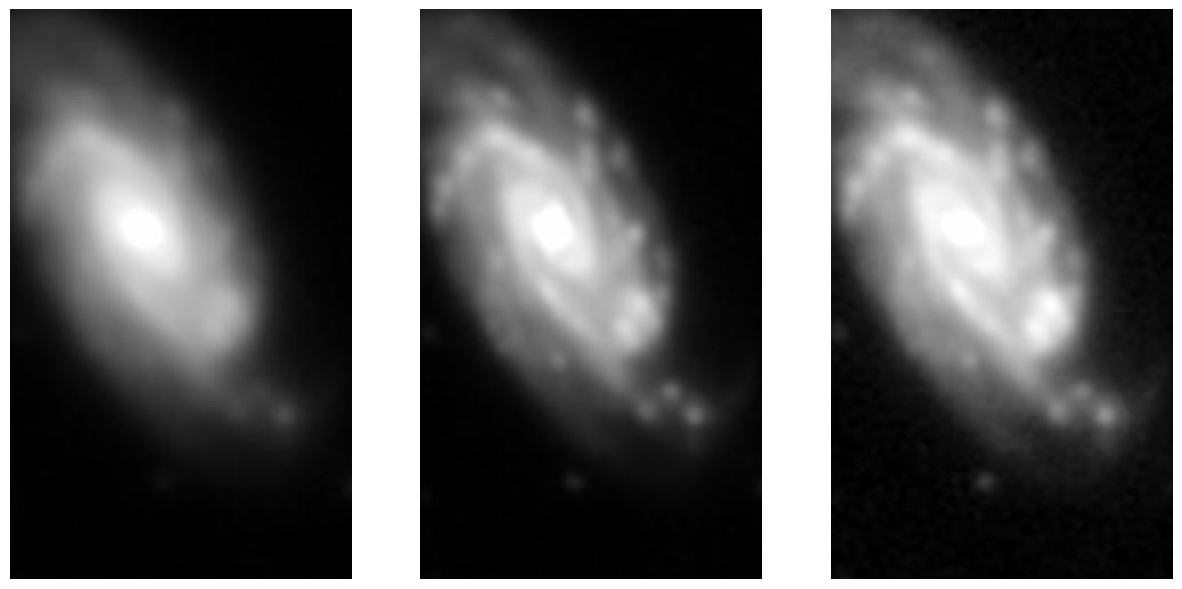

In [5]:
# Let's create a function that returns the filename based on the suprime-cam filter
def imgname(filt):
    name = ("./hlsp_3dhst_subaru_suprimecam_goods-n_"
        + filt
        + "_v4.0_sc_189.492060_62.206150_300.0pix-x-500.0pix_astrocut.jpg")
    return name

# For further convenience, assign colors to the filenames
red = imgname('rc')
green = imgname('v')
blue = imgname('b')

# Create three plots and fill them with the cutouts
fig, ax = plt.subplots(1,3, figsize=(15,10))
for i,file in enumerate([red, green, blue]):
    image = Image.open(file)
    ax[i].imshow(image,cmap="gray")
    ax[i].axis('off')

Next, we combine the three `.jpg` cutouts into a single, colorized image:

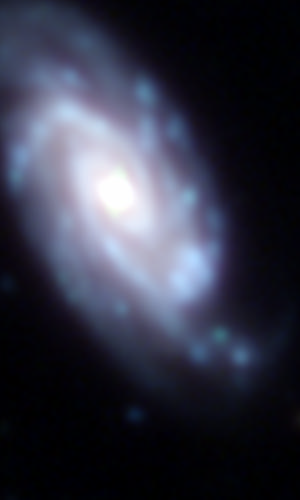

In [6]:
Image.merge("RGB", [Image.open(red), Image.open(green), Image.open(blue)])

If instead you want to create and colorize images from FITS files, you can use the built-in functions in `astropy.visualization`. More details are available [here](https://docs.astropy.org/en/stable/visualization/rgb.html).

## Getting FITS cutouts
Using a different target, we'll access the cutouts as astropy FITS objects. This time, however, we'll use the `get_cutouts` method, which does not download the file into the working directory. The images are loaded into memory but not saved.

We'll also use MAST `Catalogs` to overlay Gaia sources on our image.

**Note:** The runtime of the below cell varies, depending on the server load at the time of request. It should finish running in under 30 seconds.

In [7]:
# As before, we define our coordinates
coord = SkyCoord(53.22706, -27.90232, unit="deg")

# And request cutouts at that location
cutouts = Zcut.get_cutouts(coord, size=300)

Now, we use one of the cutouts to get its [World Coordinate System](https://fits.gsfc.nasa.gov/fits_wcs.html) (WCS) information. When plotting, we can now make sure that each pixel corresponds to its coordinates on the sky. This gives us the ability to overlay images based on coordinates.

Our overlay will be high-precision coordinates from the Gaia mission. We use the the astroquery.mast `Catalogs` class to search the Gaia database.

In [8]:
# Pull the WCS/image data from our cutout
cutout_wcs = WCS(cutouts[1][1].header)
cutout_img = cutouts[1][1].data

# Search Gaia for data in the vicinity of our target
sources = Catalogs.query_region(catalog="Gaia", coordinates=coord, radius=.5*u.arcmin)

Now we can set up our graph to show an overlay of the image and Gaia coordinates (marked with an 'x'). 

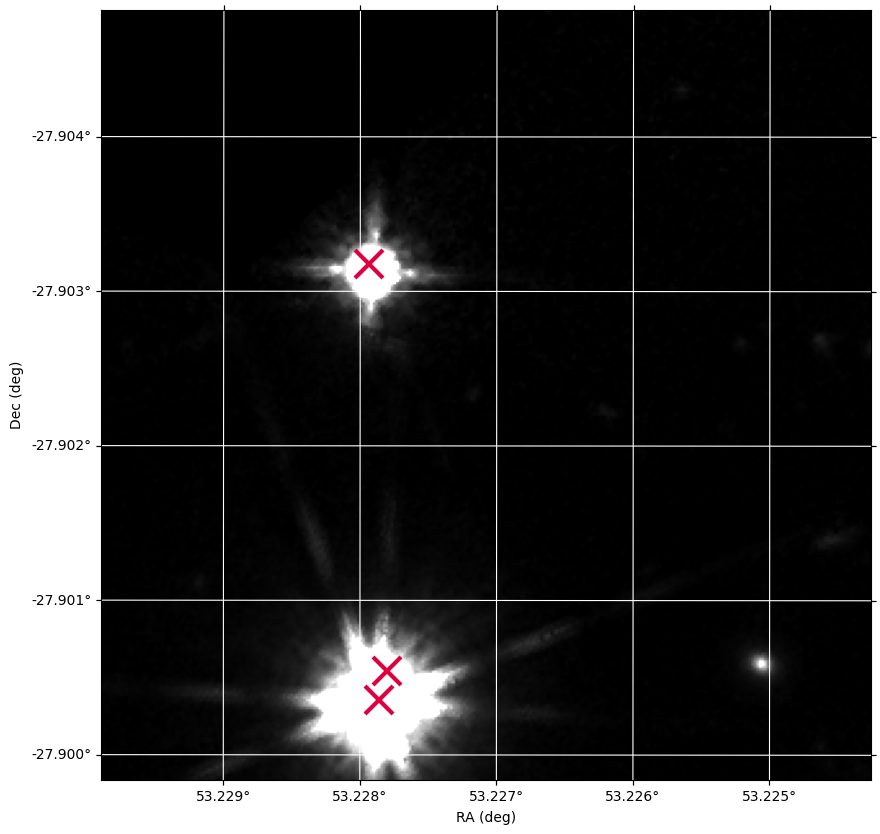

In [9]:
# Create the figure on a WCS projection
fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')

# Setup WCS axes
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")

ax.imshow(cutout_img, cmap='gray',vmin=0,vmax=1)
ax.plot(sources['ra'],sources['dec'], 'x',ms=20, mew=3, color="#df0040", transform=ax.get_transform('icrs'))

ax.set_xlim(0,cutout_img.shape[1]-1)
ax.set_ylim(cutout_img.shape[0]-1,0)

plt.show()

It's interesting to note that Gaia recognises two stars in the brightest spot of the image. At the same time, the far fainter point in the lower right is not in the Gaia catalog at all!

### For further reading
* [Gaia Mission](https://www.esa.int/Science_Exploration/Space_Science/Gaia)
* [3D-HST](https://archive.stsci.edu/prepds/3d-hst/), the deepfield survey we use in the image file example

### About this Notebook

**Authors:** Natalie Korzh, Thomas Dutkiewicz

**Last Updated:** July 2022<br>
**Next Review:** Jan 2023

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 

[Top of Page](#Beginner:-Zcut-using-Astrocut-and-Astroquery-Tutorial)